# Task 1

## Loading the packages and data, and setting the seed

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import random

from sklearn.metrics import confusion_matrix
from IPython.display import clear_output

random.seed(15102021)

Reading the 4 data files

In [39]:
#Lets read the data
test_X = pd.read_csv("test_in.csv", header = None) # row = 1000, col = 256
test_y = pd.read_csv("test_out.csv", header = None) # row = 1000, col = 1
train_X = pd.read_csv("train_in.csv", header = None) # row = 1707, col = 256
train_y = pd.read_csv("train_out.csv", header = None) # row = 1707, col = 1

#each row is one image each 16 x 16 image 

## Task 1 Exercise 1 


In [40]:
dimensions = np.arange(0,10, step = 1)
#create a dafa frame with 256 columns and 10 rows for each dimension mean
dim_i_coor_means = []
for dimension in dimensions:
    
    index = train_y.index[train_y[0] == dimension].tolist() #gets the index from the y labels
    dim_i_df = train_X.iloc[index] #gets the subset of train_X with the ith label
    dim_i_coor_means.append(dim_i_df.mean())
    

#create the dataframe  with means
#There is probably a better way of doing this. Ask Georgi
means_df = pd.DataFrame(list(zip(dim_i_coor_means[0], dim_i_coor_means[1],dim_i_coor_means[2],dim_i_coor_means[3],
                          dim_i_coor_means[4],dim_i_coor_means[5],dim_i_coor_means[6],
                          dim_i_coor_means[7],dim_i_coor_means[8],dim_i_coor_means[9]))).T
#rows are labels and columns are pixel means

In [41]:
predicted_labels = []
for picture in np.arange(0,train_X.shape[0]):#For each picture
    predicted_label = []
    for label in np.arange(0,means_df.shape[0]): # for each label
        predicted_label.append(np.linalg.norm(train_X.iloc[picture] - means_df.iloc[label]))
    predicted_labels.append(predicted_label.index(min(predicted_label)))  

Our predictions (just to show a few)

In [42]:
#Our predictions
pd.DataFrame(list(zip(predicted_labels,train_y[0].to_numpy())), columns = ["Predictions","Actual_Values"])

,Predictions,Actual_Values
0,6,6
1,5,5
2,4,4
3,7,7
4,3,3
...,...,...
1702,8,8
1703,9,9
1704,7,7
1705,9,9


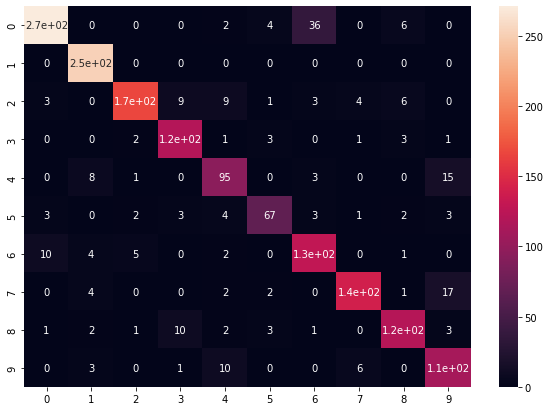

In [43]:
conf_mat= confusion_matrix(train_y[0], predicted_labels)
df_cm = pd.DataFrame(conf_mat, index = [i for i in np.arange(0,10)],
                  columns = [i for i in np.arange(0,10)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

Accuracy of our distance-based classifier

In [44]:
np.sum(np.diag(df_cm))/ len(predicted_labels)

0.8635032220269478

Looks like most wrong classifications comes from confusing 0 with 6. There are also some confusion with confusing 4 with 9 and 7 with 9. We also see that our accuracy is 0.863.

## Task 1 Exercise 2

Loading the libraries needed for PCA.

We also want to standardize the input because PCA is very "sensitive" to the scaling of the inputs.

We also did some checks to see how our PCA perform.


In [90]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
np.random.seed(15102021)
palette = sn.color_palette("bright", 10)

In [91]:
scaler = StandardScaler()
scaler.fit(train_X)
scaled_train_X = scaler.transform(train_X)

In [92]:
pca = PCA(n_components=2).fit(scaled_train_X)

X_pca = pca.transform(scaled_train_X)

In [93]:
def get_normed_mean_cov(X):
    X_std = StandardScaler().fit_transform(X)
    X_mean = np.mean(X_std, axis=0)
    
    ## Automatic:
    #X_cov = np.cov(X_std.T)
    
    # Manual:
    X_cov = (X_std - X_mean).T.dot((X_std - X_mean)) / (X_std.shape[0]-1)
    
    return X_std, X_mean, X_cov

X_std, X_mean, X_cov = get_normed_mean_cov(train_X)


In [ ]:
fig = plt.figure(figsize=(12,12))
sn.heatmap(pd.DataFrame(X_cov), annot=False, cmap='PuOr')
plt.show()

In [95]:
eigenvals, eigenvecs = np.linalg.eig(X_cov)

# Create a tuple of (eigenvalues, eigenvectors)
unsrt_eigenvalvec = [(np.abs(eigenvals[i]), eigenvecs[:,i]) for i in range(len(eigenvals))]

# Sort tuple by eigenvalues
eigenvalvec = sorted(unsrt_eigenvalvec, reverse=True, key=lambda x:x[0])

In [96]:
lam_sum = sum(eigenvals)
explained_variance = [(lam_k/lam_sum) for lam_k in sorted(eigenvals, reverse=True)]

In [ ]:
#To check the eigen values and explained variance

plt.figure(figsize=(6, 4))

plt.bar(range(len(explained_variance)), explained_variance, alpha=0.5, align='center',
        label='Individual Explained Variance $\lambda_{k}$')

plt.ylabel('Explained variance ratio')
plt.xlabel('Ranked Principal Components')
plt.title("Scree Graph")

plt.legend(loc='best')
plt.tight_layout()

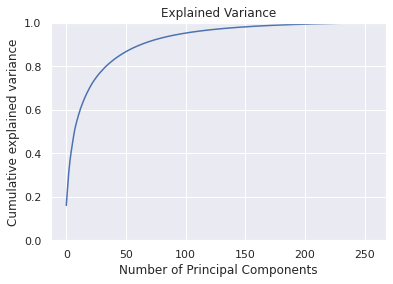

In [98]:
# To check the PCA dimensions
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)

ax1.plot(np.cumsum(explained_variance))

ax1.set_ylim([0,1.0])

ax1.set_xlabel('Number of Principal Components')
ax1.set_ylabel('Cumulative explained variance')
ax1.set_title('Explained Variance')

plt.show()

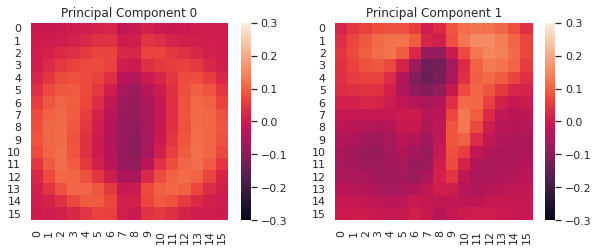

In [99]:
fig = plt.figure(figsize=(10,8))
axes = [fig.add_subplot(220+i+1) for i in range(2)]

for i,ax in enumerate(axes):
    sn.heatmap(pca.components_[i].reshape(16,16), 
                square=True, ax=ax, 
                vmax = 0.30, vmin=-0.30)
    ax.set_title('Principal Component '+str(i))
    #ax.set_xlabel('Horz Pixels')
    #ax.set_ylabel('Vert Pixels')
    
plt.show()

In [100]:
matW = np.hstack( pair[1].reshape(256,1) for pair in eigenvalvec[0:4] )
Z = X_std.dot(matW)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [101]:
#To get colors
def get_cmap(n):
    #colorz = plt.cm.cool
    colorz = plt.get_cmap('Set1')
    return [ colorz(float(i)/n) for i in range(n)]

colorz = get_cmap(10)
colors = [colorz[yy] for yy in train_y[0]]

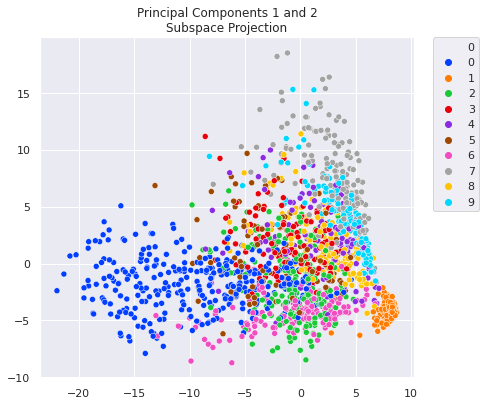

In [102]:
sn.set(rc={'figure.figsize':(6.7,6.27)})
plt.subplots()
sn.scatterplot(x=Z[:,0], y=Z[:,1], hue=train_y[0], legend='full', palette=palette).set_title('Principal Components 1 and 2\nSubspace Projection')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Locally Linear Embedding

In [105]:
from sklearn.manifold import LocallyLinearEmbedding
np.random.seed(15102021)
LLE = LocallyLinearEmbedding(n_components=2)

LLE_train_X = LLE.fit_transform(train_X)

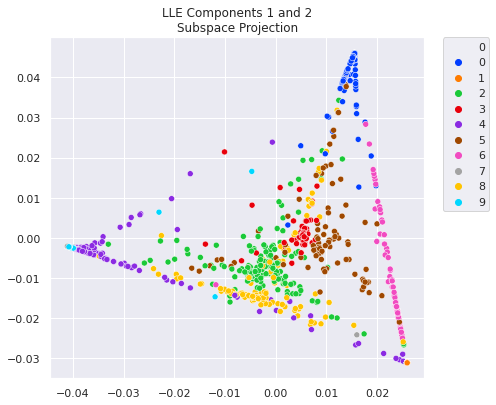

In [106]:
sn.scatterplot(x=LLE_train_X[:,0], y=LLE_train_X[:,1], hue=train_y[0], legend='full', palette=palette).set_title('LLE Components 1 and 2\nSubspace Projection')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**t-SNE Model**

In [107]:
from sklearn.manifold import TSNE
np.random.seed(15102021)
tsne = TSNE()

X_embedded = tsne.fit_transform(train_X)

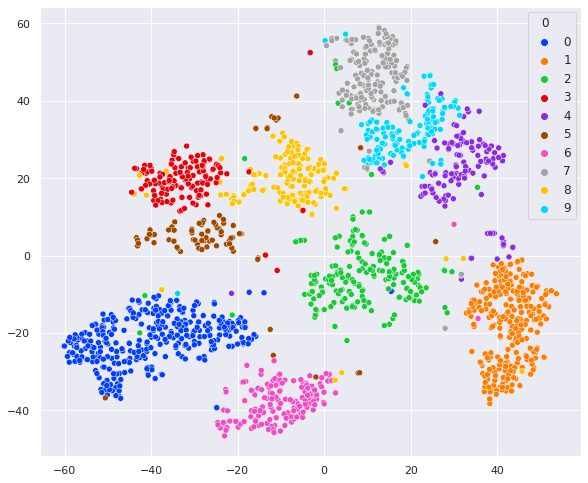

In [108]:
sn.set(rc={'figure.figsize':(9.7,8.27)})

sn.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=train_y[0], legend='full', palette=palette)

## Task 1 Exercise 3

We computed the training accuracy in task 1.1

In [62]:
predicted_labels = []
for picture in np.arange(0,test_X.shape[0]):#For each picture
    predicted_label = []
    for label in np.arange(0,means_df.shape[0]): # for each label
        predicted_label.append(np.linalg.norm(test_X.iloc[picture] - means_df.iloc[label]))
    predicted_labels.append(predicted_label.index(min(predicted_label)))  

In [63]:
pd.DataFrame(list(zip(predicted_labels,test_y[0].to_numpy())), columns = ["Predictions","Actual_Values"])

,Predictions,Actual_Values
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
995,9,9
996,5,5
997,8,8
998,9,7


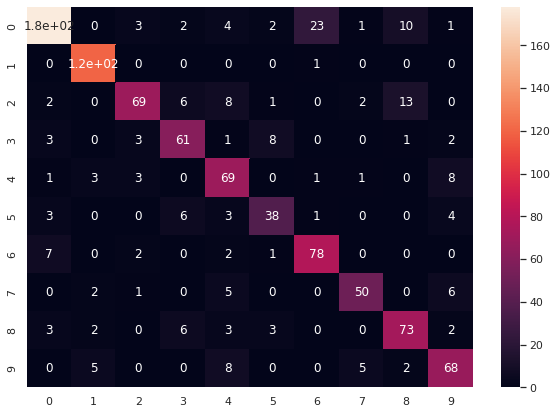

In [64]:
conf_mat= confusion_matrix(test_y[0], predicted_labels)
df_cm = pd.DataFrame(conf_mat, index = [i for i in np.arange(0,10)],
                  columns = [i for i in np.arange(0,10)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [65]:
#Accuracy 
np.sum(np.diag(df_cm))/ len(predicted_labels)

0.804

So our Accuracy is not 0.80 on our test set, which is lower than the accuracy on our training set.

## Task 1 Exercise 4

Apply KNN now

In [66]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_X, train_y[0])

#to get the predictions

predictions_train = neigh.predict(train_X)
predictions_test = neigh.predict(test_X)

In [67]:
predictions_test.shape

(1000,)

Text(0.5, 1.0, 'Confusion matrix of KNN for training data')

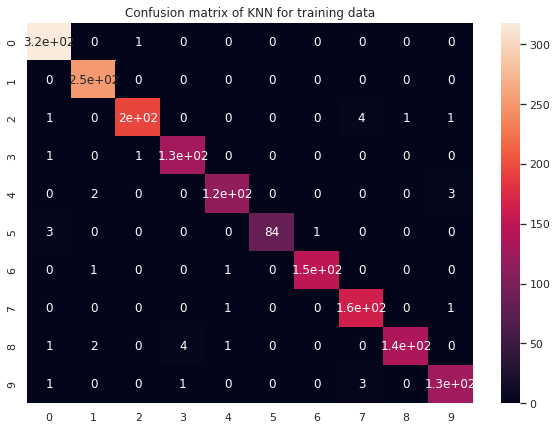

In [68]:
#First for the training set
conf_mat= confusion_matrix(train_y[0], predictions_train)
df_cm = pd.DataFrame(conf_mat, index = [i for i in np.arange(0,10)],
                  columns = [i for i in np.arange(0,10)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True).set_title("Confusion matrix of KNN for training data")

In [69]:

#Accuracy 
np.sum(np.diag(df_cm))/ len(predictions_train)


0.9789103690685413

Our accuracy on our training data is 0.97 which is quite high compared to our distance-based model. 

Now lets check our test set accuracy and its confusion matrix.

Text(0.5, 1.0, 'Confusion matrix of KNN for test data')

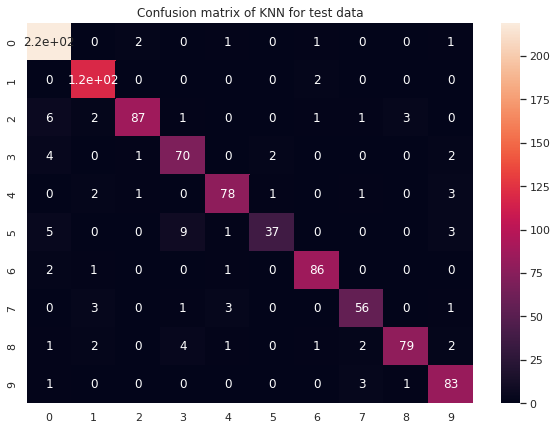

In [70]:
#First for the training set
conf_mat= confusion_matrix(test_y[0], predictions_test)
df_cm = pd.DataFrame(conf_mat, index = [i for i in np.arange(0,10)],
                  columns = [i for i in np.arange(0,10)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True).set_title("Confusion matrix of KNN for test data")

In [71]:
#Accuracy 
np.sum(np.diag(df_cm))/ len(predictions_test)


0.914

As expected we see a lower accuracy on our test data (Accuracy = 0.914) compare to our training data. That being said, the KNN works much better than the distance model.

# Task 2

Here we build the multiclass perceptron

In [72]:
def multi_class_perceptron(train_X, train_y, epochs, weights = False):
    all_weights = np.random.uniform(-1,1,(10,train_X.shape[1]+1))
    X = np.hstack((np.ones((train_X.shape[0], 1)), np.array(train_X)))
    Z = np.dot(X, all_weights.T)
    predictions = np.argmax(Z, axis = 1)
    comparison = predictions != train_y[0] #wrong labels
    epoch = 0
    current_accuracy = 1 - sum(comparison)/ len(comparison)

    accuracies_for_plot = []

    while epoch < epochs:

        last_accuracy = current_accuracy
    
        for i in range(comparison.shape[0]):

            if comparison[i] == True: # If we label it wrongly
                correct_label = train_y[0][i] 
                cor_label_prediction = Z[i][correct_label]
                more_activated = np.where(Z[0] > Z[0][correct_label]) # the nodes that are more activated compared to the correct one
                for j in more_activated: #update weights for the wrongly activated nodes
                    all_weights[j] = all_weights[j] - X[i]
        
                all_weights[correct_label] = all_weights[correct_label] + X[i]
    
        Z = np.dot(X,all_weights.T )
        predictions = np.argmax(Z, axis = 1)
        comparison = predictions != train_y[0] 
        current_accuracy = 1 - sum(comparison)/ len(comparison)
        epoch += 1

        accuracies_for_plot.append(current_accuracy)
        N = len(accuracies_for_plot)

        if (epoch % 50 == 0):
          clear_output(wait=True)
          plt.plot(range(0, N), accuracies_for_plot)
          plt.show()

        accuracy_difference = current_accuracy - last_accuracy
        if accuracy_difference > 0 and accuracy_difference <= 0.0006 :
          print("The algorithm converged!")
          print(f"Final accuracy: {current_accuracy} at epoch {epoch}")
          break

    if weights:
      return(all_weights)

In [73]:
def Predict_perceptron(test_X,test_y,weights):
  X = np.hstack((np.ones((test_X.shape[0], 1)), np.array(test_X)))
  Z = np.dot(X, weights.T)
  predictions = np.argmax(Z, axis = 1)
  comparison = predictions != test_y[0] #wrong labels
  accuracy = 1 - sum(comparison)/ len(comparison)

  print(f"Accuracy on the training set is {accuracy}")

To get an idea how the training goes, we made an interactive plot (it is updated once every 50 epoch)

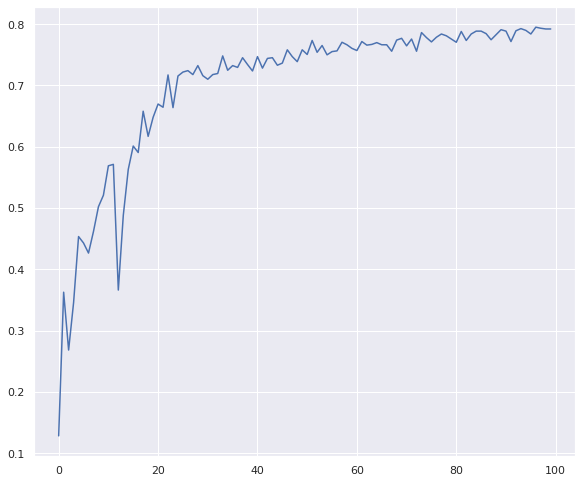

The algorithm converged!
Final accuracy: 0.7920328060925601 at epoch 118


In [74]:
np.random.seed(1337)
multi_class_perceptron(train_X, train_y, 2000)

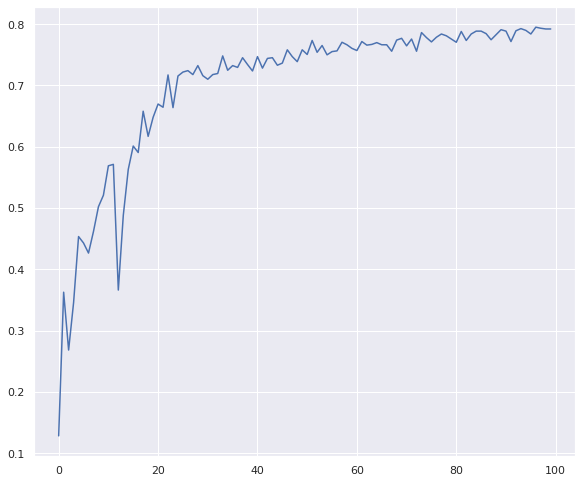

The algorithm converged!
Final accuracy: 0.7920328060925601 at epoch 118
Accuracy on the training set is 0.71


In [75]:
np.random.seed(1337)
weights = multi_class_perceptron(train_X,train_y,2000, weights = True)
Predict_perceptron(test_X,test_y,weights)

# Task 3

Define the activation function (sigmoid) and its derivative

In [76]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_der(x):
    return sigmoid(x) * (1 - sigmoid(x))

Define the Xor_net function that simulates the forward pass

In [77]:
def Xor_net(x1, x2, weights, predict = False):
    bias = 1
    
    input_net = np.array([bias, x1,x2])
    
    z0_dot = np.dot(input_net,weights[0:3].reshape(1,3).T)
    z0 = sigmoid(z0_dot)
    
    z1_dot = np.dot(input_net,weights[3:6].reshape(1,3).T)
    z1 = sigmoid(z1_dot)
    hidden_net= np.array([bias,z0,z1])
    z2_dot = np.dot(hidden_net,weights[6:9].reshape(1,3).T)[0]
    
    z2 = sigmoid(z2_dot)
    
    if predict == True:
        return(z2)
    
    return (np.concatenate([z0_dot,z1_dot,z2_dot]))

Define the MSE function that returns the average squared error on every possible x1 and x2 inputs

In [78]:
def Mse(weights):
    x1 = np.array([0,0,1,1])
    x2 = np.array([0,1,0,1])
    
    results = []
    actual = np.array([0, 1, 1, 0])
    for i in np.arange(4):
        result = Xor_net(x1[i],x2[i],weights, True)
        
        if result >= 0.5:
            results.append(1)
            
        else:
            results.append(0)
            
    return (np.square(np.array(results) - actual)).mean()

Defining the Delta functions that are used in the backpropagation algorithm 


In [79]:
def Delta_hidden(x1,x2,net,net1, u,d):
    w0 = (sigmoid(net) - d) * sigmoid_der(net) * u *  sigmoid_der(net1) 
    w1 = (sigmoid(net) - d) * sigmoid_der(net) * u *  sigmoid_der(net1) * x1 
    w2 = (sigmoid(net) - d) * sigmoid_der(net) * u *  sigmoid_der(net1) * x2
    
    return (np.array([w0,w1,w2]))

def Delta_output(y1,y2,net,d):
    w0 = (sigmoid(net) - d) * sigmoid_der(net)
    w1 = (sigmoid(net) - d) * sigmoid_der(net) * y1
    w2 = (sigmoid(net) - d) * sigmoid_der(net) * y2
    
    return (np.array([w0,w1,w2]))

In [80]:
def Grdmse(x1,x2,weights,d):

    z0_dot,z1_dot,z2_dot = Xor_net(x1,x2,weights, False)
    
    w_z0 = Delta_hidden(x1 = x1, x2 = x2,net = z2_dot, net1 = z0_dot, u = weights[7], d = d)
    w_z1 = Delta_hidden(x1 = x1, x2 = x2,net = z2_dot, net1 = z1_dot, u = weights[8], d = d)
    w_z2 = Delta_output(sigmoid(z0_dot),sigmoid(z1_dot),z2_dot,d)
    
    return np.concatenate((w_z0,w_z1,w_z2))

In [81]:
x1 = np.array([1,1,0,0])
x2 = np.array([1,0,1,0])
y = np.array([0,1,1,0])


def train_network(lr, weights_init, print_convergences = None):  
  weights = weights_init

  epochs = 50000
  epoch = 0
  while epoch < epochs:
      epoch += 1
      for i in np.arange(4):
          weights = weights - lr * Grdmse(x1[i],x2[i], weights, y[i])
      if Mse(weights) == 0:
          print(f"Converged in {epoch} epochs. Learning rate was {lr}")
          break    
      if (epoch % 100 == 0) and print_convergences is not None:
        print(f"Not converged on iteration: {epoch} with MSE = {Mse(weights)} and the number of misclassified inputs {int(Mse(weights) * 4)} ")
      if epoch == epochs:
        print(f"NN couldn't converge in {epochs} epochs. Learning rate was {lr}")

In [82]:
np.random.seed(15102021)
experiment_lr = [0.05, 0.1, 0.2, 0.5]
weights_normal = np.random.normal(0, 1, 9)
weights_uniform = np.random.uniform(-1, 1, 9)
weights_normal_moved = np.random.normal(2, 1, 9)
weights_normal_high_var = np.random.normal(0, 2, 9)

weights_list = [weights_normal, weights_uniform, weights_normal_moved, weights_normal_high_var]

Testing learning rates

In [ ]:
for lr in experiment_lr:
  train_network(lr, weights_normal)

As we can see, the higher the learning rate, the faster the convergence. Of course, this is not entirely correct, because the XOR network is very simple. For complex Neural Networks a smaller learning rate is preferred. Choosing the learning rate in that case is arbitrary, but we should stick to something lower like 0.05

In [ ]:
for weight in weights_list:
  train_network(0.05, weight)

For the weights, we decided to use $w \sim N(2,1)$ since it converges faster in several starts we did. To conclude, here is our final model.

In [ ]:
train_network(0.05,weights_normal_moved, print_convergences = True)